# Metropolitan Housing Price Analysis

#### Parker Davie
#### ISYE 6414

In [1]:
#Imports
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from scipy.stats import skew, randint

The data was procured through Zillow, the National Zoning and Land Use Database, and Urban Institute. The data is grouped by core-based statistical areas (CBSA) in the US. CityNames is used as a crosswalk for Zillow, which uses RegionID, and the others, which use cbsa10. 

In [2]:
#Load Zillow dataset
df1 = pd.read_csv("Metro_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_month.csv", usecols=["RegionID", "SizeRank", "RegionName", "2025-01-31"])
df1 = df1.rename(columns={'2025-01-31': 'Zillow_Home_Value'})

#Load CityNames crosswalk dataset
df2 = pd.read_csv("CityNames.csv", usecols=["RegionID", "cbsa10"])
df2["cbsa10"] = df2["cbsa10"].astype('Int64').astype(str)

#Load NZLUD dataset
df3 = pd.read_csv("nzlud_msa.csv", usecols=['cbsa10', 'responses', 'restrict_sf_permit', 'restrict_mf_permit',
       'limit_sf_units', 'limit_mf_units', 'limit_mf_dwellings',
       'limit_mf_dwelling_units', 'min_lot_size', 'open_space', 'inclusionary',
       'half_acre_less', 'half_acre_more', 'one_acre_more', 'two_acre_more',
       'total_nz', 'total_rz', 'maxden5', 'maxden4', 'maxden3', 'maxden2',
       'maxden1', 'adu', 'height_ft_median', 'height_ft_mode',
       'height_st_median', 'height_st_mode', 'parking_median', 'parking_mode',
       'zri_median'])
df3["cbsa10"] = df3["cbsa10"].astype(str)

#Load Urban Institute dataset
df4 = pd.read_csv('Unified_data.csv', usecols=[
    "CBSA_GISJOIN", "CBSA_HSG_20", "CBSA_MED_HH_INC_19", 
    "CBSA_BA_PLUS_19", "POP_19", "AREA_SQM_20"
])

#Aggregate functions for the Urban Institute dataset
agg_functions = {
    'CBSA_HSG_20': 'mean',
    'CBSA_MED_HH_INC_19': 'mean',
    'CBSA_BA_PLUS_19': 'mean',
    'POP_19': 'sum',
    'AREA_SQM_20': 'sum'
}

#Group data by cbsa10 and apply aggregation to the columns
df4 = df4.groupby('CBSA_GISJOIN').agg(agg_functions).reset_index()

#Rename and convert CBSA to match the others
df4["cbsa10"] = df4["CBSA_GISJOIN"].str.lstrip("G")
df4["cbsa10"] = df4["cbsa10"].astype(str)


#Join datasets and drop NULL values
df = df1.merge(df2, on="RegionID", how="inner")
df = df.merge(df3, on="cbsa10", how="inner")
df = df.merge(df4.drop(columns="CBSA_GISJOIN"), on="cbsa10", how="inner").dropna()

#Show dataframe
print(df.head(10))

#Show shape of new dataset
shape = df.shape
print(shape)

   RegionID  SizeRank        RegionName  Zillow_Home_Value cbsa10  responses  \
0    394913         1      New York, NY       6.951709e+05  35620        108   
1    753899         2   Los Angeles, CA       1.002067e+06  31080         48   
2    394463         3       Chicago, IL       3.368000e+05  16980        106   
3    394514         4        Dallas, TX       3.708453e+05  19100         48   
4    394692         5       Houston, TX       3.093948e+05  26420         20   
5    395209         6    Washington, DC       6.012010e+05  47900         15   
6    394974         7  Philadelphia, PA       3.685094e+05  37980         59   
7    394856         8         Miami, FL       5.700576e+05  33100         36   
8    394347         9       Atlanta, GA       3.823985e+05  12060         30   
9    394404        10        Boston, MA       7.258756e+05  14460         57   

   restrict_sf_permit  restrict_mf_permit  limit_sf_units  limit_mf_units  \
0            0.009259            0.009259 

Dropping all rows with NA values reduces the dataset by a large margin, however this is done to ensure all columns are accounted for.

Correlations are shown between the target, Zillow Home Value, and the other factors.

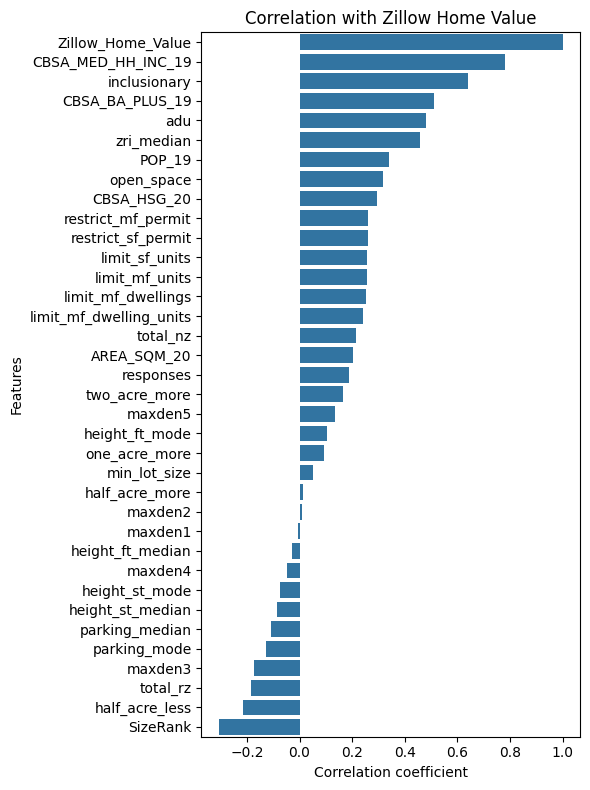

In [3]:
#Show correlations 
corr_set = df.drop(columns=['RegionID', 'RegionName', 'cbsa10'])
corrs = corr_set.corr()['Zillow_Home_Value'].sort_values(ascending=False)

plt.figure(figsize=(6, 8))
sns.barplot(x=corrs.values, y=corrs.index)

plt.title('Correlation with Zillow Home Value')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')

plt.tight_layout()
plt.show()

CBSA_MED_HH_INC_19, inclusionary, CBSA_BA_PLUS_19, adu, and zri_median seem to be the most correlated factors.

After data preprocessing, a random forest model is created using the Zillow Home Value Index as the target variable. Data is given an 80/20 train test split.

In [4]:
#Random Forest

X = df.drop(columns=['Zillow_Home_Value', 'RegionID', 'RegionName', 'cbsa10'])
y = df['Zillow_Home_Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)

rf_model = RandomForestRegressor(n_estimators=100, random_state=6)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=6)

In [5]:
#Model evaluation

#Predictions
train_preds = rf_model.predict(X_train)
test_preds = rf_model.predict(X_test)

#R-Squared
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

#MSE
train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)

print(f"Train R-squared: {train_r2:f}")
print(f"Test R-squared: {test_r2:f}")
print(f"Train MSE: {train_mse:f}")
print(f"Test MSE: {test_mse:f}")

Train R-squared: 0.962620
Test R-squared: 0.585999
Train MSE: 1698347354.982781
Test MSE: 7199667518.651282


In [6]:
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')

print("Cross-validated R-squared scores:", cv_scores)
print("Average R-squared:", np.mean(cv_scores))

Cross-validated R-squared scores: [0.60430671 0.7755768  0.74727164 0.50917979 0.68631375]
Average R-squared: 0.6645297379574576


The train R-squared result is very high, where the test R-squared result is much lower, but still not terrible. Both MSE results seem unrealistically high. Using cross validation, the average R-squared is between the test and train results at a good 0.66.

Using permutation importance on the random forest model, we can see what seems to be the most important factors at the moment.

In [7]:
#Permutation importance
result = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=6)
sorted_idx = result.importances_mean.argsort()[::-1]
for i in sorted_idx[:10]:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:f}")

CBSA_MED_HH_INC_19: 0.494417
inclusionary: 0.258629
total_rz: 0.022971
adu: 0.017097
open_space: 0.016784
AREA_SQM_20: 0.006792
zri_median: 0.005907
one_acre_more: 0.005658
half_acre_less: 0.005207
SizeRank: 0.003315


These results are very similar to the correlation results, however CBSA_BA_PLUS_19 seems to be less important.

A simple linear regression model is trained to verify the data and results are reasonable.

In [8]:
l_model = LinearRegression()
l_model.fit(X_train, y_train)
y_train_pred_lin = l_model.predict(X_train)
y_test_pred_lin = l_model.predict(X_test)

print(f"Linear Train R-squared: {r2_score(y_train, y_train_pred_lin):f}")
print(f"Linear Test R-squared: {r2_score(y_test, y_test_pred_lin):f}")

Linear Train R-squared: 0.830057
Linear Test R-squared: 0.442999


These results seem reasonable.

In order to try to optimize the random forest model, GridSearch is used to find the best hyperparameters.

In [ ]:
#Random forest using gridsearch
gs_rf_model = RandomForestRegressor(random_state=16)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=gs_rf_model,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated R-squared Score:", grid_search.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}
Best Cross-Validated R-squared Score: 0.5933870245711478


Now, a random forest model is created using the hyperparameters from gridsearch.

In [10]:
gs_rf = RandomForestRegressor(
    max_depth=10,
    max_features='sqrt',
    min_samples_split=5,
    n_estimators=100,
    random_state=6
)

gs_rf.fit(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)

gs_rf.fit(X_train, y_train)

y_train_pred = gs_rf.predict(X_train)
y_test_pred = gs_rf.predict(X_test)

print("Train R-squared:", r2_score(y_train, y_train_pred))
print("Test R-squared:", r2_score(y_test, y_test_pred))
print("Test RMSE:", mean_squared_error(y_test, y_test_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))

Train R-squared: 0.9238947485598785
Test R-squared: 0.5434865081846603
Test RMSE: 7938980996.129747
Test MAE: 71449.21061141495


In [11]:
cv_scores = cross_val_score(gs_rf, X, y, cv=5, scoring='r2')
print("Cross-validated R-squared scores:", cv_scores)
print("Average R-squared:", cv_scores.mean())

Cross-validated R-squared scores: [0.43183592 0.69017831 0.66777552 0.56548908 0.48064653]
Average R-squared: 0.567185073157274


The results with the tuned hyperparameters are actually worse than the original model.

To further try to create a better model, we can check for skew in the target data and see what we can do about it.

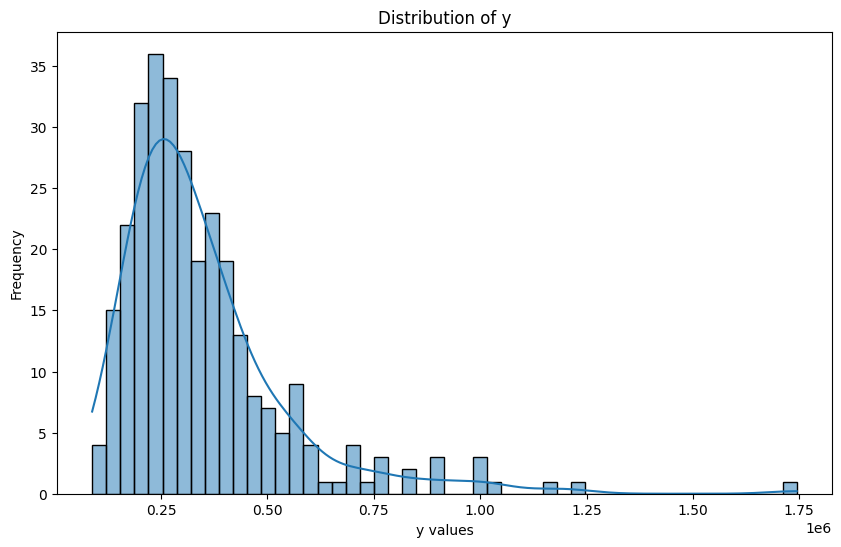

Skew of y: 2.517419


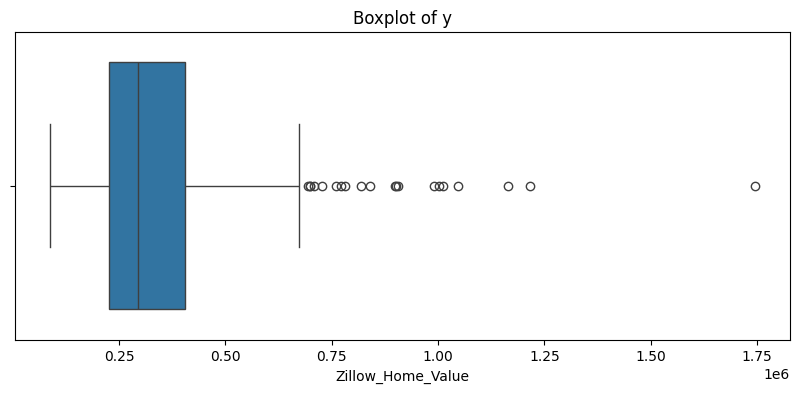

Number of outliers: 20
Outlier threshold: Lower: -44056.723183 Upper: 675011.194176


In [13]:
#Histogram of target
plt.figure(figsize=(10,6))
sns.histplot(y, kde=True, bins=50)
plt.title('Distribution of y')
plt.xlabel('y values')
plt.ylabel('Frequency')
plt.show()

#Skew
y_skew = skew(y)
print(f"Skew of y: {y_skew:f}")

#Boxplot for outliers
plt.figure(figsize=(10,4))
sns.boxplot(x=y)
plt.title('Boxplot of y')
plt.show()

#Find outliers
q1 = np.percentile(y, 25)
q3 = np.percentile(y, 75)
qrange = q3 - q1
lb = q1 - 1.5 * qrange
ub = q3 + 1.5 * qrange

outliers = y[(y < lb) | (y > ub)]
print(f"Number of outliers: {len(outliers)}")
print(f"Outlier threshold: Lower: {lb:f} Upper: {ub:f}")

The data has a positive skew value, which can be clearly seen in the histogram. There are 20 outliers in the high range of the Zillow Home Value, however I chose to not remove them as they are real values of houses and could be useful in the model.

To deal with the skew, log is used on the target variable to normalize the data.

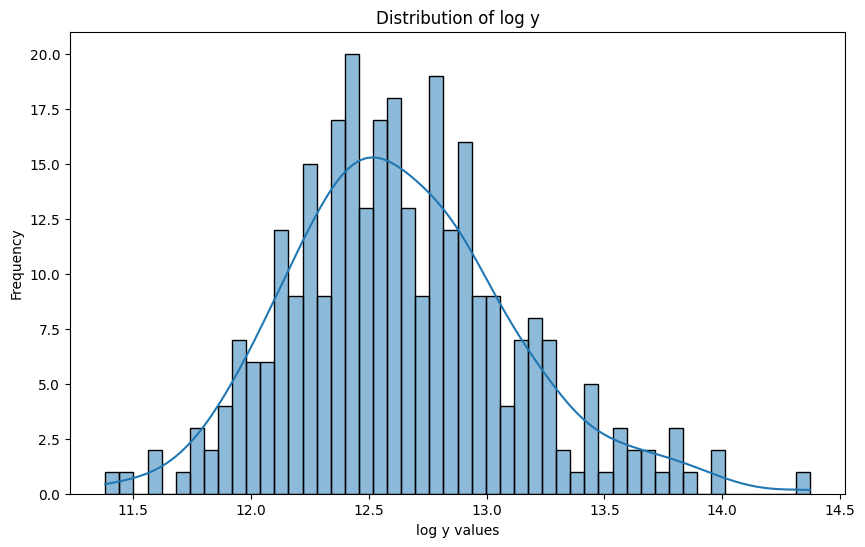

Skew of log y: 0.468605


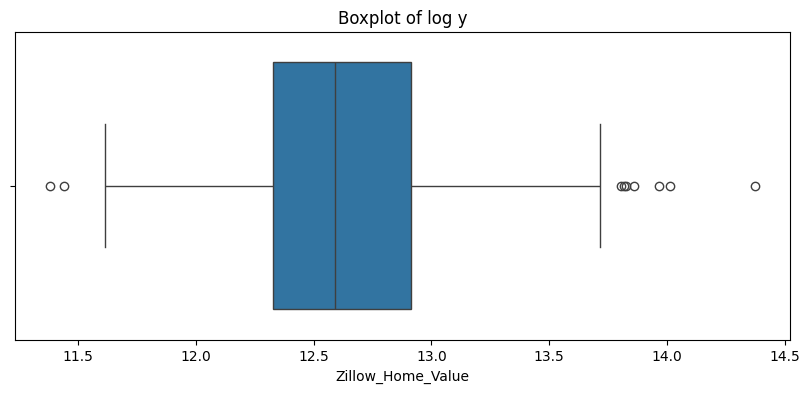

Number of outliers: 9
Outlier threshold: Lower: 11.447423 Upper: 13.791602


In [14]:
#Histogram with log
plt.figure(figsize=(10,6))
sns.histplot(np.log1p(y), kde=True, bins=50)
plt.title('Distribution of log y')
plt.xlabel('log y values')
plt.ylabel('Frequency')
plt.show()

log_y_skew = skew(np.log1p(y))
print(f"Skew of log y: {log_y_skew:f}")

#Boxplot for outliers
plt.figure(figsize=(10,4))
sns.boxplot(x=np.log1p(y))
plt.title('Boxplot of log y')
plt.show()

#Find outliers
q1 = np.percentile(np.log1p(y), 25)
q3 = np.percentile(np.log1p(y), 75)
qrange = q3 - q1
lb = q1 - 1.5 * qrange
ub = q3 + 1.5 * qrange

outliers = np.log1p(y)[(np.log1p(y) < lb) | (np.log1p(y) > ub)]
print(f"Number of outliers: {len(outliers)}")
print(f"Outlier threshold: Lower: {lb:f} Upper: {ub:f}")


Though there are still outliers, the skew value is much lower, and the histogram looks much more normally distributed. Outliers are also less abundant and less extreme.

Now a random forest model will be created with log(y).

In [15]:
#Random forest using log
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

log_rf = RandomForestRegressor(
    max_depth=20,
    max_features='sqrt',
    min_samples_split=2,
    n_estimators=200,
    random_state=6
)
log_rf.fit(X_train, y_train_log)

y_train_log_pred = log_rf.predict(X_train)
y_test_log_pred = log_rf.predict(X_test)

y_train_pred = np.expm1(y_train_log_pred)
y_test_pred = np.expm1(y_test_log_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Train R-squared: {train_r2:f}")
print(f"Test R-squared: {test_r2:f}")
print(f"Test RMSE: {test_rmse:f}")
print(f"Test MAE: {test_mae:f}")

cv_scores = cross_val_score(log_rf, X, np.log1p(y), cv=5, scoring='r2')
print(f"Cross-validated R-squared scores: {cv_scores}")
print(f"Average R-squared: {np.mean(cv_scores):f}")

Train R-squared: 0.933900
Test R-squared: 0.601081
Test RMSE: 83290.942846
Test MAE: 64239.338817
Cross-validated R-squared scores: [0.55662739 0.69936219 0.66506541 0.51815537 0.4756711 ]
Average R-squared: 0.582976


Using log on the target results in a similar cross-validated r-squared value, but much more reasonable RMSE and MAE values.

Now to use log while trying to get the best hyperparameters, a random forest model is created using log and RandomizedSearchCV.

In [ ]:
y_log = np.log1p(y)

X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=6)

rs_log_rf = RandomForestRegressor(random_state=6)

#parameters for RandomizedSearchCV to try
param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(5, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
}

random_search = RandomizedSearchCV(rs_log_rf, param_dist, n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=6)

random_search.fit(X_train, y_train_log)

rs_log_rf = random_search.best_estimator_

y_pred_log = rs_log_rf.predict(X_test)

y_pred = np.expm1(y_pred_log)

train_pred_log = rs_log_rf.predict(X_train)
train_pred = np.expm1(train_pred_log)

train_r2 = r2_score(np.expm1(y_train_log), train_pred)
test_r2 = r2_score(np.expm1(y_test_log), y_pred)
test_rmse = np.sqrt(mean_squared_error(np.expm1(y_test_log), y_pred))
test_mae = np.mean(np.abs(np.expm1(y_test_log) - y_pred))

print("Best hyperparameters from RandomizedSearchCV:", random_search.best_params_)
print(f"Train R-squared: {train_r2}")
print(f"Test R-squared: {test_r2}")
print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")

cv_scores = cross_val_score(rs_log_rf, X, np.log1p(y), cv=5, scoring='r2')
print(f"Cross-validated R-squared scores: {cv_scores}")
print(f"Average R-squared: {np.mean(cv_scores):f}")

Best hyperparameters from RandomizedSearchCV: {'bootstrap': False, 'max_depth': 11, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 88}
Train R-squared: 0.9715310786167606
Test R-squared: 0.631424986182872
Test RMSE: 80060.54050991368
Test MAE: 62848.17316209326
Cross-validated R-squared scores: [0.55789805 0.6957436  0.68633004 0.50295796 0.48958409]
Average R-squared: 0.586503


This method results in a very similar cross validated R-squared score to the other models.

Lastly, a reduced model is created using all the methods combined to see if lowering the number of features can create a better model. To do this, the most important features are listed, and a model is created from this list.

In [17]:
perm_importance = permutation_importance(rs_log_rf, X_test, y_test_log, n_repeats=10, random_state=6)
importances = perm_importance.importances_mean
important_features = X_test.columns[importances > 0.01]

print("Top features:", list(important_features))

Top features: ['limit_sf_units', 'open_space', 'inclusionary', 'adu', 'zri_median', 'CBSA_MED_HH_INC_19', 'CBSA_BA_PLUS_19']


In [20]:
X_train_important = X_train[important_features]
X_test_important = X_test[important_features]

rf_model_reduced = RandomForestRegressor(
    max_depth=11,
    max_features='log2',
    min_samples_split=2,
    min_samples_leaf=3,
    n_estimators=88,
    random_state=6
)

rf_model_reduced.fit(X_train_important, y_train_log)

y_train_pred_log = rf_model_reduced.predict(X_train_important)
y_test_pred_log = rf_model_reduced.predict(X_test_important)

y_train_pred_reduced = np.expm1(y_train_pred_log)
y_train_reduced = np.expm1(y_train_log)
y_pred = np.expm1(y_test_pred_log)
y_test = np.expm1(y_test_log)

train_r2_reduced = r2_score(y_train_reduced, y_train_pred_reduced)
r2_reduced = r2_score(y_test, y_pred)
rmse_reduced = np.sqrt(mean_squared_error(y_test, y_pred))
mae_reduced = mean_absolute_error(y_test, y_pred)

print(f"Reduced Model Train R-squared: {train_r2_reduced:f}")
print(f"Reduced Model Test R-squared: {r2_reduced:f}")
print(f"Reduced Model RMSE: {rmse_reduced:f}")
print(f"Reduced Model MAE: {mae_reduced:f}")

Reduced Model Train R-squared: 0.831445
Reduced Model Test R-squared: 0.676534
Reduced Model RMSE: 75001.547729
Reduced Model MAE: 59618.504799


From this final model, the most important features are ranked.

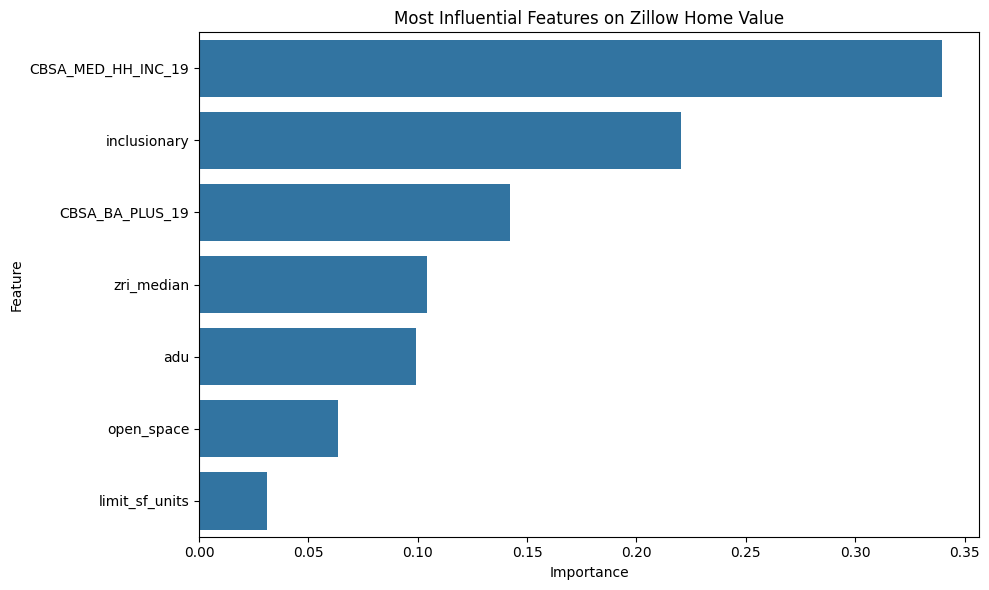

              Feature  Importance
5  CBSA_MED_HH_INC_19    0.339815
2        inclusionary    0.220265
6     CBSA_BA_PLUS_19    0.142069
4          zri_median    0.104212
3                 adu    0.099165
1          open_space    0.063410
0      limit_sf_units    0.031063


In [22]:
#Feature importance
importance = rf_model_reduced.feature_importances_
feature_names = important_features

feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(15))
plt.title('Most Influential Features on Zillow Home Value')
plt.tight_layout()
plt.show()

print(feat_importance_df)

The final R-Squared value was 0.6765, with an RMSE of 75001.55 and an MAE of 59618.5. This result suggests that the included variables do influence the Zillow Home Value Index. The five most influential factors found were median household income, whether there is an inclusionary zoning program or not, the share of those above age 25 with higher education, the median Zoning Restrictiveness Index score, and whether accessory dwelling units are allowed or not.